# Test post length confound
One potential confound in the study of context: what if context use is correlated with post length? I.e. authors who tend to write long posts also include context? We'll try to prove that this is not true.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# load data
anchor_data_file = '../../data/mined_tweets/combined_tweet_tag_data_NE_flat_parsed_anchor.gz'
anchor_data = pd.read_csv(anchor_data_file, sep='\t', index_col=False, compression='gzip')
anchor_data.fillna('', inplace=True)

In [3]:
# compute post length
## same thing but remove anchor phrase
txt_var = 'txt'
clean_txt_var = 'txt_clean'
anchor_txt_var = 'anchor_phrase'
anchor_data = anchor_data.assign(**{clean_txt_var : anchor_data.apply(lambda x: x.loc[txt_var].lower().replace(x.loc[anchor_txt_var], ''), axis=1)})
len_var = '%s_len'%(txt_var)
anchor_data = anchor_data.assign(**{len_var : np.log(anchor_data.loc[:, clean_txt_var].apply(lambda x: len(x)))})
# cleanup 
max_char_len = 280
anchor_data = anchor_data[anchor_data.loc[:, len_var] <= np.log(max_char_len)]

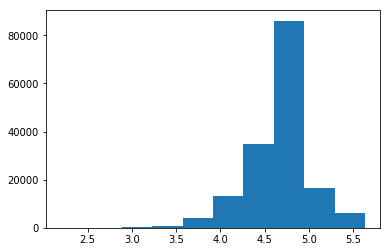

In [4]:
plt.hist(anchor_data.loc[:, len_var])
plt.show()

### Compare text vs. P(anchor)
Let's keep it simple and split the data into length quantiles.

In [5]:
N_bin = 10
bins = np.linspace(anchor_data.loc[:, len_var].min(), anchor_data.loc[:, len_var].max(), N_bin)
anchor_data = anchor_data.assign(**{'%s_bin'%(len_var) : np.digitize(anchor_data.loc[:, len_var], bins)})
print(np.exp(bins))
bin_counts = anchor_data.loc[:, '%s_bin'%(len_var)].value_counts().sort_index()
print(bin_counts)

[  9.          13.18627145  19.31975053  28.30616388  41.47252897
  60.76311387  89.02654597 130.43646684 191.10785101 280.        ]
1        17
2        44
3       341
4      1959
5      8213
6     29355
7     69764
8     46253
9      6591
10      129
Name: txt_len_bin, dtype: int64


In [6]:
anchor_data[anchor_data.loc[:, len_var] == anchor_data.loc[:, len_var].min()].head()

,id,txt,data_name_fixed,username,date,lang,NE,NE_type,NE_LOC,valid_loc,...,max_population_diff,max_alternate_name_count_anchor,max_alternate_name_count_diff,parse,max_alternate_names,anchor,anchor_phrase,txt_clean,txt_len,txt_len_bin
18007,901584704931057664,"Port Aransas, Texas. #Harvey",harvey,"#Irma,#HurricaneIrma,#Harvey,#HurricaneHarvey_...",2017-08-26 19:18:00,en,Port Aransas,LOCATION,True,True,...,22871734.0,True,74.0,"[[['Port', 'PROPN', 2, 'compound', 0], ['Arans...",6.0,1.0,"port aransas, texas",. #harvey,2.197225,1
19290,901817038024429568,"Houston, Texas. #Harvey",harvey,"#Irma,#HurricaneIrma,#Harvey,#HurricaneHarvey_...",2017-08-27 10:41:00,en,Houston,LOCATION,True,True,...,20579465.0,True,20.0,"[[['Houston', 'PROPN', 1, 'compound', 0], ['Te...",60.0,1.0,"houston, texas",. #harvey,2.197225,1


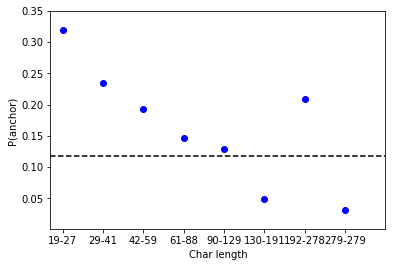

In [7]:
anchor_var = 'anchor'
anchor_prob_mean = anchor_data.loc[:, anchor_var].mean()
anchor_prob_by_bin = anchor_data.groupby('%s_bin'%(len_var)).apply(lambda x: x.loc[:, anchor_var].mean())
# only plot bins with reasonable count
min_bin_count = 50
bin_counts = anchor_data.loc[:, '%s_bin'%(len_var)].value_counts()
valid_bins = sorted(bin_counts[bin_counts >= min_bin_count].index)
anchor_prob_by_bin = anchor_prob_by_bin.loc[valid_bins]
anchor_prob_by_bin.sort_index(inplace=True)
plt.scatter(anchor_prob_by_bin.index, anchor_prob_by_bin.values, color='b')
## add horizontal line for overall prob
plt.plot([anchor_prob_by_bin.index.min()*.9, anchor_prob_by_bin.index.max()*1.1], [anchor_prob_mean, anchor_prob_mean], linestyle='--', color='k')
plt.xlim([anchor_prob_by_bin.index.min()*.9, anchor_prob_by_bin.index.max()*1.1])
## fix x ticks
bin_ranges = anchor_data.groupby('%s_bin'%(len_var)).apply(lambda x: (np.exp(x.loc[:, len_var].min()), np.exp(x.loc[:, len_var].max())))
bin_ranges = bin_ranges.loc[anchor_prob_by_bin.index]
bin_ranges_str = ['%d-%d'%(x[0], x[1]) for x in bin_ranges]
plt.xticks(anchor_prob_by_bin.index, bin_ranges_str)
plt.xlabel('Char length')
plt.ylabel('P(anchor)')
plt.show()

Overall: a negative correlation between anchor use and non-context tweet length. This is the opposite of what we expected, where length ~ formality ~ more context.

In [8]:
np.random.seed(123)
bootstrap = 100
bootstrap_size = 10000
anchor_prob_samples = []
for i in range(bootstrap):
    anchor_data_i = anchor_data.loc[np.random.choice(anchor_data.index, bootstrap_size, replace=False), :]
    anchor_prob_by_bin = anchor_data_i.groupby('%s_bin'%(len_var)).apply(lambda x: x.loc[:, anchor_var].mean())
    bin_counts = anchor_data_i.loc[:, '%s_bin'%(len_var)].value_counts()
#     anchor_prob_by_bin = anchor_prob_by_bin.loc[bin_counts[bin_counts >= min_bin_count].index]
    anchor_prob_by_bin = anchor_prob_by_bin.loc[valid_bins]
    anchor_prob_by_bin.sort_index(inplace=True)
    anchor_prob_samples.append(anchor_prob_by_bin)
anchor_prob_samples = pd.concat(anchor_prob_samples, axis=1).transpose()

In [9]:
display(anchor_prob_samples.head())

txt_len_bin,3,4,5,6,7,8,9,10
0,0.120000,0.216000,0.191268,0.148438,0.128624,0.049929,0.219697,0.0
1,0.312500,0.219178,0.180527,0.155259,0.124091,0.048476,0.191710,0.0
2,0.269231,0.245614,0.203390,0.151515,0.126810,0.050484,0.223022,0.0
3,0.260870,0.197080,0.203846,0.126589,0.119441,0.054073,0.193878,0.0
4,0.321429,0.273585,0.205761,0.143581,0.128884,0.040923,0.188776,0.0


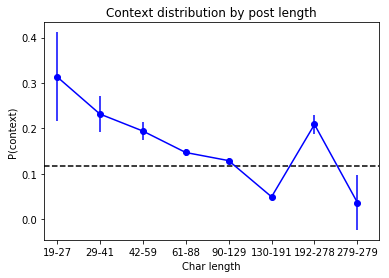

In [10]:
anchor_prob_samples_vals = [anchor_prob_samples.loc[:, c].dropna(inplace=False) for c in valid_bins]
# compute mean, err
anchor_prob_samples_vals_mean = [x.mean() for x in anchor_prob_samples_vals]
# anchor_prob_samples_vals_stderr = [1.96 * x.std() / x.shape[0]**.5 for x in anchor_prob_samples_vals]
anchor_prob_samples_vals_stderr = [x.std() for x in anchor_prob_samples_vals]
plt.scatter(valid_bins, anchor_prob_samples_vals_mean, color='b')
plt.errorbar(valid_bins, anchor_prob_samples_vals_mean, yerr=anchor_prob_samples_vals_stderr, color='b', linestyle=None)
plt.plot([min(valid_bins)*.9, max(valid_bins)*1.1], [anchor_prob_mean, anchor_prob_mean], linestyle='--', color='k')
plt.xlim([min(valid_bins)*.9, max(valid_bins)*1.05])
bin_ranges = anchor_data.groupby('%s_bin'%(len_var))e.apply(lambda x: (np.exp(x.loc[:, len_var].min()), np.exp(x.loc[:, len_var].max())))
bin_ranges = bin_ranges.loc[anchor_prob_by_bin.index]
bin_ranges_str = ['%d-%d'%(x[0], x[1]) for x in bin_ranges]
plt.xticks(valid_bins, bin_ranges_str)
plt.xlabel('Char length')
plt.ylabel('P(context)')
plt.title('Context distribution by post length')
## TODO: overlay with bin count
plt.show()

Overall most posts tend to have around the expected probability of context.

### Separate by data set

Maybe we need to subset by data set (since some datasets were collected before the switch to 280 chars).

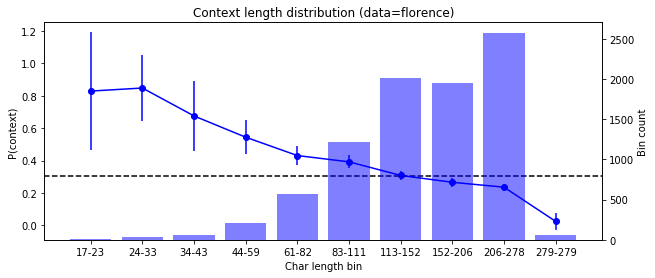

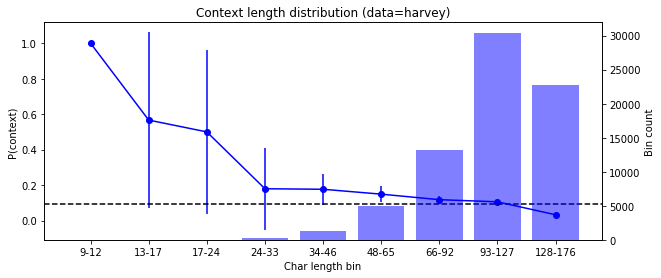

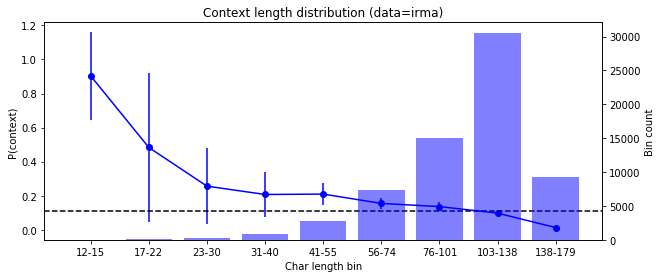

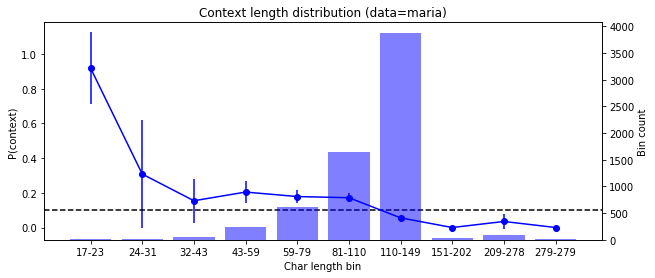

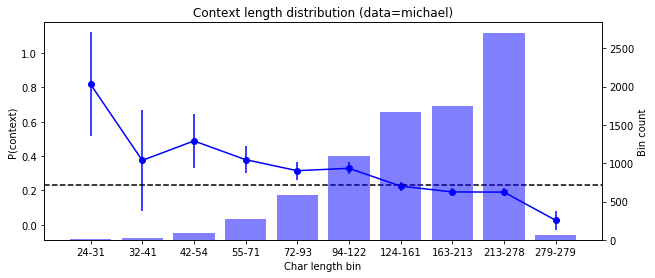

In [12]:
data_name_var = 'data_name_fixed'
for name_i, data_i in anchor_data.groupby(data_name_var):
    # re-bin data, etc.
    N_bin = 10
    bins = np.linspace(data_i.loc[:, len_var].min(), data_i.loc[:, len_var].max(), N_bin)
    data_i = data_i.assign(**{'%s_bin'%(len_var) : np.digitize(data_i.loc[:, len_var], bins)})
    bin_counts = data_i.loc[:, '%s_bin'%(len_var)].value_counts().sort_index()
    np.random.seed(123)
    bootstrap = 100
    bootstrap_size = 1000
    anchor_prob_samples = []
    for b in range(bootstrap):
        anchor_data_b = data_i.loc[np.random.choice(data_i.index, bootstrap_size, replace=False), :]
        anchor_prob_by_bin = anchor_data_b.groupby('%s_bin'%(len_var)).apply(lambda x: x.loc[:, anchor_var].mean())
    #     anchor_prob_by_bin = anchor_prob_by_bin.loc[bin_counts[bin_counts >= min_bin_count].index]
#         anchor_prob_by_bin = anchor_prob_by_bin.loc[valid_bins]
        anchor_prob_by_bin.sort_index(inplace=True)
        anchor_prob_samples.append(anchor_prob_by_bin)
    anchor_prob_samples = pd.concat(anchor_prob_samples, axis=1).transpose()
    valid_bins = anchor_prob_samples.columns
    anchor_prob_samples_vals = [anchor_prob_samples.loc[:, c].dropna(inplace=False) for c in valid_bins]
    # compute mean, err
    anchor_prob_samples_vals_mean = [x.mean() for x in anchor_prob_samples_vals]
    # anchor_prob_samples_vals_stderr = [1.96 * x.std() / x.shape[0]**.5 for x in anchor_prob_samples_vals]
    anchor_prob_samples_vals_stderr = [x.std() for x in anchor_prob_samples_vals]
    anchor_prob_mean = data_i.loc[:, anchor_var].mean()
    ## two y axes: P(anchor) and bin count
    f, ax1 = plt.subplots(figsize=(10, 4))
    ax2 = ax1.twinx()
    ax1.scatter(valid_bins, anchor_prob_samples_vals_mean, color='b')
    ax1.errorbar(valid_bins, anchor_prob_samples_vals_mean, yerr=anchor_prob_samples_vals_stderr, color='b', linestyle=None)
    bin_range = max(valid_bins) - min(valid_bins)
    bin_range_buffer = .1*bin_range
    ax1.plot([min(valid_bins) - bin_range_buffer, max(valid_bins) + bin_range_buffer], [anchor_prob_mean, anchor_prob_mean], linestyle='--', color='k')
    ax1.set_xlim([min(valid_bins) - bin_range_buffer, max(valid_bins) + bin_range_buffer])
    bin_ranges = data_i.groupby('%s_bin'%(len_var)).apply(lambda x: (np.exp(x.loc[:, len_var].min()), np.exp(x.loc[:, len_var].max())))
    bin_ranges_str = ['%d-%d'%(x[0], x[1]) for x in bin_ranges]
    ax1.set_xticks(valid_bins)
    ax1.set_xticklabels(bin_ranges_str)
    ax1.set_xlabel('Char length bin')
    ax1.set_ylabel('P(context)')
    ## overlay with bin count
    ax2.bar(valid_bins, bin_counts.loc[valid_bins], color='b', alpha=0.5)
    ax2.set_ylabel('Bin count')
#     ax2.set_yscale('log')
    plt.title('Context length distribution (data=%s)'%(name_i))
    plt.show()

OK! There is again a slight negative correlation between length and context probability but for the most part, there is not much variation among the most frequent bins (all roughly centered around mean).

### Normalize post length per data set
Let's do the same test but after normalizing length per dataset (0-1).

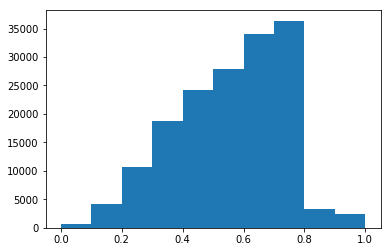

In [19]:
anchor_data_len_norm = []
data_name_var = 'data_name_fixed'
len_var = 'txt_len'
len_smooth = 1e-3
for name_i, data_i in anchor_data.groupby(data_name_var):
    max_len = np.exp(data_i.loc[:, len_var].max())
    min_len = np.exp(data_i.loc[:, len_var].min())
    len_range = max_len - min_len
    data_i = data_i.assign(**{
        '%s_norm'%(len_var) : (np.exp(data_i.loc[:, len_var]) - min_len) / len_range
    })
    anchor_data_len_norm.append(data_i)
anchor_data_len_norm = pd.concat(anchor_data_len_norm, axis=0)
plt.hist(anchor_data_len_norm.loc[:, '%s_norm'%(len_var)])
plt.show()

In [48]:
# bin again
N_bins = 11
norm_var = 'txt_len_norm'
norm_bin_var = '%s_bin'%(norm_var)
norm_len_bins = np.linspace(anchor_data_len_norm.loc[:, norm_var].min(), anchor_data_len_norm.loc[:, norm_var].max(), num=N_bins)
anchor_data_len_norm = anchor_data_len_norm.assign(**{
    norm_bin_var : np.digitize(anchor_data_len_norm.loc[:, norm_var], norm_len_bins)
})
display(anchor_data_len_norm.loc[:, norm_bin_var].value_counts().sort_index())

1       618
2      4188
3     10608
4     18840
5     24249
6     27908
7     34123
8     36369
9      3303
10     2329
11      131
Name: txt_len_norm_bin, dtype: int64

### Plot norm length vs. P(context)

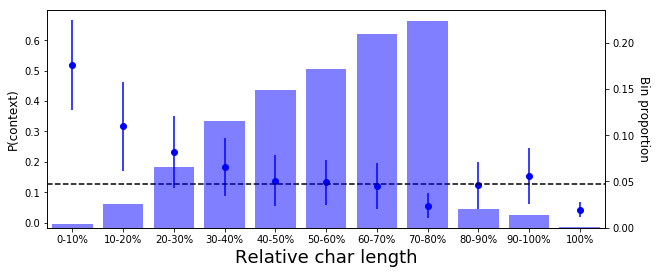

In [74]:
NE_var = 'NE_fixed'
anchor_var = 'anchor'
anchor_prob_mean = anchor_data_len_norm.groupby([data_name_var, NE_var]).apply(lambda x: x.loc[:, anchor_var].mean()).mean()
anchor_prob_mean_by_bin = anchor_data_len_norm.groupby(norm_bin_var).apply(lambda x: x.groupby([data_name_var, NE_var]).apply(lambda y: y.loc[:, anchor_var].mean()).mean()).sort_index()
anchor_prob_sd_by_bin = anchor_data_len_norm.groupby(norm_bin_var).apply(lambda x: x.groupby([data_name_var, NE_var]).apply(lambda y: y.loc[:, anchor_var].std() / (y.shape[0]**.5)).mean()).sort_index()
norm_bin_counts = anchor_data_len_norm.loc[:, norm_bin_var].value_counts().sort_index()
norm_bin_counts = norm_bin_counts / norm_bin_counts.sum()
f, ax1 = plt.subplots(figsize=(10, 4))
ax2 = ax1.twinx()
ax1.scatter(anchor_prob_mean_by_bin.index, anchor_prob_mean_by_bin.values, color='b')
ax1.errorbar(anchor_prob_mean_by_bin.index, anchor_prob_mean_by_bin.values, yerr=anchor_prob_sd_by_bin, linestyle='none', color='b')
# ## add horizontal line for overall prob
min_bin = anchor_prob_mean_by_bin.index.min()
max_bin = anchor_prob_mean_by_bin.index.max()
bin_range_buffer = 0.05 * (max_bin - min_bin)
ax1.plot([min_bin-bin_range_buffer, max_bin+bin_range_buffer], [anchor_prob_mean, anchor_prob_mean], linestyle='--', color='k')
ax1.set_xlim([min_bin-bin_range_buffer, max_bin+bin_range_buffer])
## fix x ticks
bin_pcts_str = ['%d-%d%%'%(norm_len_bins[i]*100, norm_len_bins[i+1]*100) for i in range(N_bins-1)]
bin_pcts_str.append('%d%%'%(norm_len_bins[-1]*100))
# bin_ranges = bin_ranges.loc[anchor_prob_by_bin.index]
ax1.set_xticks(anchor_prob_mean_by_bin.index)
ax1.set_xticklabels(bin_pcts_str)
ax1.set_xlabel('Relative char length', fontsize=18)
ax1.set_ylabel('P(context)', fontsize=12)
## add bin counts
ax2.bar(anchor_prob_mean_by_bin.index, norm_bin_counts, color='b', alpha=0.5)
ax2.set_ylabel('Bin proportion', fontsize=12, rotation=270, labelpad=16)
plt.show()